# Computing nucleation rates with GASP

In [1]:
%matplotlib inline

In [2]:
import numpy as np  # Grids are stored as NumPy Arrays
import gasp         # GASP is what we're testing
import sys          # Needed to query size in bytes of data returned

import os.path

Found 1 CUDA devices in this system
Device 0 : Quadro P2000
Number of SMs       : 8
Max SHMEM per block : 48 KB
Max Opt in shared   : 48 KB
Recommended ngrids  : 1024

Estimated largest L for shared memory code path : 109
(Assumes threadsPerBlock = 32)

Using CUDA device : 0


### Run a test nucleation swarm

In [3]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 50000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                 grid_output_int = grid_output_int,
                                 mag_output_int=mag_output_int,
                                 keep_grids = False);

 Sweep :      46700, Reached cv =   0.90 : 1024 , Unresolved :    0
CPU times: user 21.5 s, sys: 4.69 s, total: 26.2 s
Wall time: 1min 22s


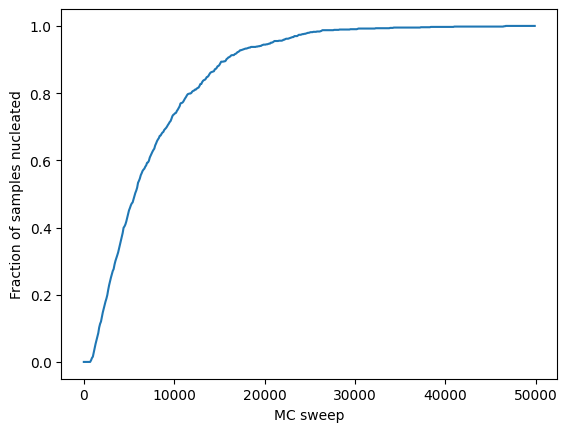

In [4]:
# Plot the fraction nucleated against MC sweep
import matplotlib.pyplot as plt

xdata = [ i * mag_output_int for i in range(nsweeps//mag_output_int)]
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("MC sweep")
plt.plot(xdata, frac);

Now for some maths.

For an exponential distribution the probability that a nucleation event will occur after time $t$ is:
$$
P(t) = \exp{(-\lambda t)}.
$$
The cumulative probability that it will have occured at a time upto time $t$ is:
$$
C(t) = \int_0^t \exp{(-\lambda t')}\, dt' = 1 - \exp{(-\lambda t)}.
$$
So we want to fit this to our data and extract $\lambda$. If the fit is poor we know this isn't an exponential process, i.e. we're not in the regime where nucleation events are a random Poisson process.



In [5]:
# Define function to fit
import math as m
def fitfunc(t, rate, t_ind):
    return 1.0 - np.exp(-rate*(t-t_ind))    

# Test function
fitfunc(2000, 0.00008, 0)

0.14785621103378865

In [6]:
# Fit it
from scipy.optimize import curve_fit
# We should only fit from the last zero entry to account for induction time
arglist = np.argwhere(frac)
si = arglist[0][0] - 1

popt, pcov = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 
popt[0]

0.00015032167327565373

Nucleation rate at L=64 : 3.66996e-08 MCSS^-1


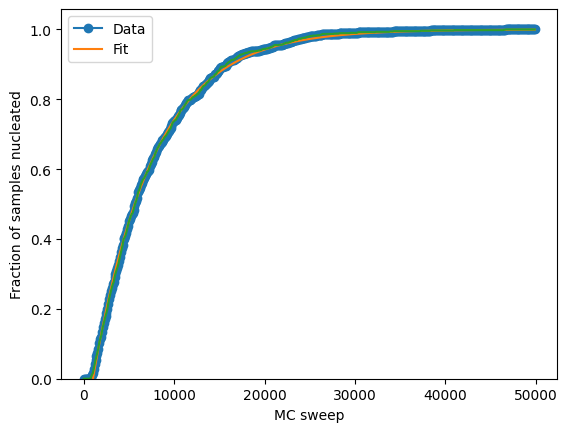

In [7]:
fitdata = [ fitfunc(t, *popt) for t in xdata]
plt.plot(xdata, frac, label="Data", marker='o')
plt.plot(xdata, fitdata, label="Fit")
plt.ylabel("Fraction of samples nucleated")
plt.xlabel("MC sweep")
plt.ylim(bottom=0.0)
plt.legend()
plt.plot(xdata, frac);

krate = popt[0]/(L*L)
print(f"Nucleation rate at L={L} : {krate:.5e} MCSS^-1")

### Run with larger L and check for finite size effects
Creating a function for compute nucleation rate as we go

In [8]:
def compute_nucleation_rate(L, ngrids, nsweeps, beta, h):
    ''' Computes nucleation rate. '''

    # Check if a file containing the data for the current inputs exists, if so just load that?
    
    frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                     grid_output_int = grid_output_int,
                                     mag_output_int=mag_output_int,
                                     keep_grids = False);

    if frac[-1] < 1.0/ngrids:
        # Nothing nucleated return zero as the nucleation rate
        return 0.0
    
    xdata = [ i * mag_output_int for i in range(nsweeps//mag_output_int)]
    arglist = np.argwhere(frac)
    si = arglist[0][0] - 1

    popt, pcov = curve_fit(fitfunc, xdata[si:], frac[si:], p0=[0.00008, 1000]) 
    krate = popt[0]/(L*L)
    return krate 

In [9]:
L=100
krate = compute_nucleation_rate(L, ngrids, nsweeps, beta, h)
print(f"Nucleation rate at L={L} : {krate:.5e} MCSS^-1")

 Sweep :      18600, Reached cv =   0.90 : 1024 , Unresolved :    0
Nucleation rate at L=100 : 3.38589e-08 MCSS^-1


### Vary external field keeping temperature the same at $\beta=0.54$

In [10]:
beta = 0.54
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.04, 0.11, 0.01) 

In [20]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h) for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

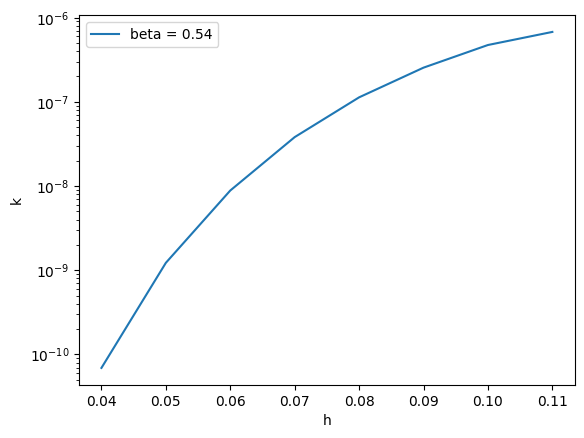

In [21]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Keep h the same and vary beta

In [ ]:
h = 0.07
L = 64
nsweeps = 500000
grid_output_int = 100000
blist = np.arange(0.52, 0.61, 0.01) 

In [24]:
filename="h"+str(h)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h) for beta in blist ]
    np.savez(filename, blist, klist)
else:
    data = np.load(filename+".npz")
    blist = data['arr_0']
    klist = data['arr_1']

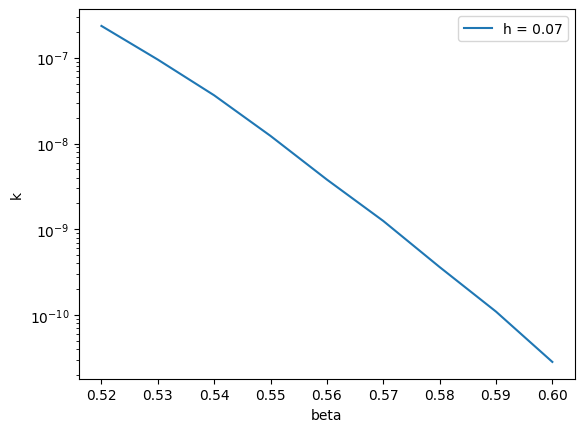

In [25]:
plt.xlabel('beta')
plt.ylabel('k')
plt.plot(blist, klist, label='h = '+str(h))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta = 0.53$

In [26]:
beta = 0.53
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.04, 0.11, 0.01) 

In [27]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h) for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

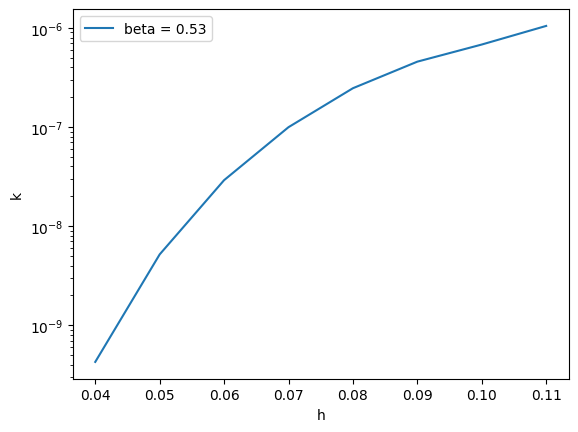

In [28]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta = 0.55$

In [29]:
beta = 0.55
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.04, 0.11, 0.01) 

In [31]:

filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h) for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

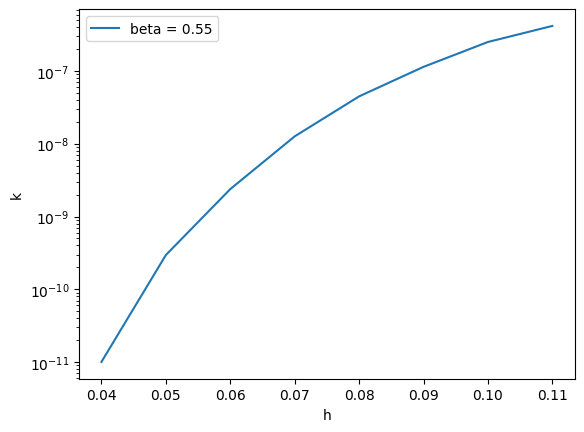

In [32]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta = 0.56$

In [39]:
beta = 0.56
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.06, 0.11, 0.01) 

In [40]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h) for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

 Sweep :     499900, Reached cv =   0.90 :  743 , Unresolved :  281
 Sweep :     499900, Reached cv =   0.90 : 1023 , Unresolved :    1
 Sweep :     121700, Reached cv =   0.90 : 1024 , Unresolved :    0
 Sweep :      54800, Reached cv =   0.90 : 1024 , Unresolved :    0
 Sweep :      13000, Reached cv =   0.90 : 1024 , Unresolved :    0


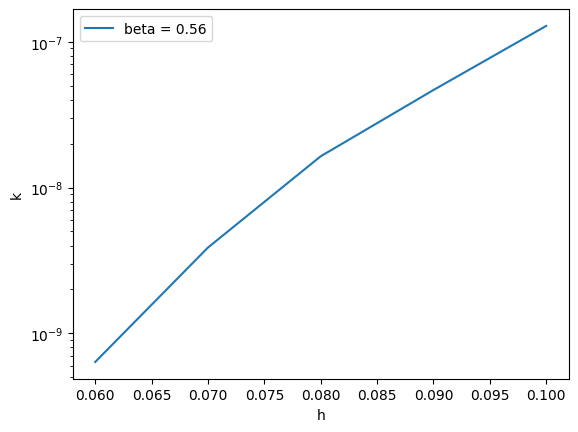

In [41]:
plt.xlabel('h')
plt.ylabel('k')
plt.plot(hlist, klist, label='beta = '+str(beta))
plt.yscale("log")
plt.legend()

### Vary $h$ at $\beta=0.57$

In [45]:
beta = 0.57
L = 64
nsweeps = 500000
grid_output_int = 100000
hlist = np.arange(0.07, 0.12, 0.01) 

In [46]:
filename="beta"+str(beta)+"_rates"
if not os.path.exists(filename+".npz"):
    klist = [ compute_nucleation_rate(L, ngrids, nsweeps, beta, h) for h in hlist ]
    np.savez(filename, hlist, klist)
else:
    data = np.load(filename+".npz")
    hlist = data['arr_0']
    klist = data['arr_1']

 Sweep :     499900, Reached cv =   0.90 :  937 , Unresolved :   87
 Sweep :     297200, Reached cv =   0.90 : 1024 , Unresolved :    0
 Sweep :      91500, Reached cv =   0.90 : 1024 , Unresolved :    0
 Sweep :      46800, Reached cv =   0.90 : 1024 , Unresolved :    0
 Sweep :      15100, Reached cv =   0.90 : 1024 , Unresolved :    0


### Combine results so far

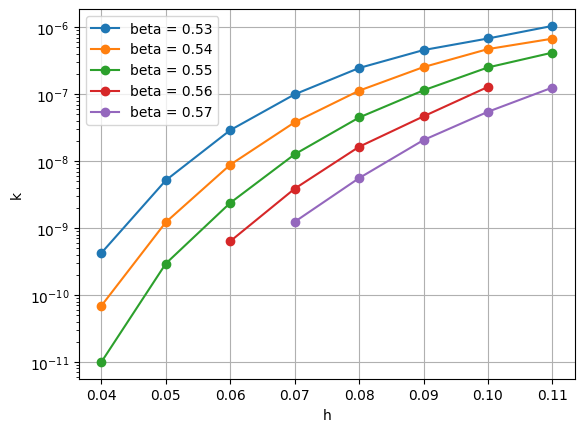

In [49]:
plt.xlabel('h')
plt.ylabel('k')
for beta in [0.53, 0.54, 0.55, 0.56, 0.57]:
    filename="beta"+str(beta)+"_rates.npz"
    dat = np.load(filename)
    hlist = dat['arr_0'] ; klist = dat['arr_1']
    plt.plot(hlist, klist, label='beta = '+str(beta), marker="o")

plt.yscale("log")
plt.legend()
plt.grid()